In [1]:
import numpy as np
import pandas as pd
from os.path import join
import os
from pylab import rcParams
import matplotlib.pyplot as plt

import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM, Hart85
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 14 days


In [2]:
import sys

In [41]:
sys.path.append("../common")
sys.path.append("../../common")



In [3]:
sys.path.append("../../code/fridge/")

In [4]:
ds = DataSet("/Users/nipunbatra/Downloads/wikienergy-2.h5")
fridges = nilmtk.global_meter_group.select_using_appliances(type='fridge')

In [6]:
fridges_id_building_id = {i:fridges.meters[i].building() for i in range(len(fridges.meters))}

In [7]:
fridge_id_building_id_ser = pd.Series(fridges_id_building_id)

In [7]:
fridge_id_building_id_ser.head()

0      1
1      1
2     10
3    101
4    102
dtype: int64

In [9]:
from fridge_compressor_durations_optimised_jul_7 import compressor_powers, defrost_power

In [10]:
fridge_ids_to_consider = compressor_powers.keys()

In [11]:
len(fridge_ids_to_consider)

96

In [12]:
building_ids_to_consider = fridge_id_building_id_ser[fridge_ids_to_consider]

In [15]:

building_ids_to_consider[110]

236

In [16]:
f_id = 110
b_id = 236
elec = ds.buildings[b_id].elec
mains = elec.mains()

In [27]:
h = Hart85()
h.train(elec.mains())

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


In [28]:
%matplotlib inline

In [42]:
from common_functions import latexify, format_axes

ImportError: No module named common_functions

In [29]:
h2 = h.pair_df['T1 Active']

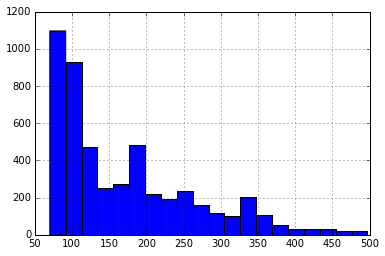

In [37]:
h2[(h2<500)].hist(bins=20)

In [38]:
h.centroids

,"(power, active)"
0,175.930963
1,1631.123948
2,4791.549957
3,2798.353876


In [30]:
for f_id, b_id in building_ids_to_consider.head(3).iteritems():
    # Need to put it here to ensure that we have a new instance of the algorithm each time
    cls_dict = {"Hart": Hart85()}
    elec = ds.buildings[b_id].elec
    mains = elec.mains()
    elec.appliances
    fridge_instance = fridges.meters[f_id].appliances[0].identifier.instance
    # Dividing train, test
    train_fraction = 0.5
    train = DataSet("/Users/nipunbatra/Downloads/wikienergy-2.h5")
    test = DataSet("/Users/nipunbatra/Downloads/wikienergy-2.h5")
    split_point = elec.train_test_split(train_fraction=train_fraction).date()
    train.set_window(end=split_point)
    test.set_window(start=split_point)
    train_elec = train.buildings[b_id].elec
    test_elec = test.buildings[b_id].elec
    test_mains = test_elec.mains()
    
    # Fridge elec
    fridge_elec = train_elec[('fridge', fridge_instance)]
    fridge_df = fridge_elec.load().next()[('power','active')]
    
    h = Hart85()
    h.train(train_elec.mains())
    fridge_power = fridge_df[fridge_df>20].mean()
    d = (h.centroids-fridge_power).abs()
    ix_d = d.sort(ascending=True).head(1).index.values[0]
   
    
    
    


Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
   (power, active)
0       119.442932
1      2603.024606    (power, active)
0        18.463969
1      2502.045643
   (power, active)
0       119.442932
1      2603.024606    (power, active)
0       230.557068
1      2253.024606
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
   (power, active)
0       119.904124
1       375.425843    (power, active)
0         3.785845
1       251.735873
   (power, active)
0       119.904124
1       375.425843    (power, active)
0       280.095876
1        24.574157
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
   (power, active)
0       145.791

In [33]:
d.sort(ascending=True).head(1).index.values[0]

0

In [24]:
d.sort(ascending=True).head(2)

,"(power, active)"
0,1.667995
1,309.980182


In [17]:
disag_filename
disag = DataSet(disag_filename)
disag_elec = disag.buildings[b_id].elec

In [18]:
disag_elec.plot()


In [52]:
fridge_elec in top_k_train_elec.meters

False

In [54]:
fridge_elec not in top_k_train_elec.meters

True

In [8]:
building_number = 11
fridge_id = 2

In [9]:
elec = ds.buildings[building_number].elec
mains = elec.mains()
elec.appliances



[Appliance(type='fridge', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='electric water heating appliance', instance=1),
 Appliance(type='spin dryer', instance=1),
 Appliance(type='electric furnace', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='sockets', instance=2),
 Appliance(type='air conditioner', instance=1),
 Appliance(type='sockets', instance=3),
 Appliance(type='sockets', instance=4)]

In [32]:
split_point = elec.train_test_split(train_fraction=0.2)

In [33]:
split_point.date()

datetime.date(2014, 2, 24)

In [34]:
train = DataSet("/Users/nipunbatra/Downloads/wikienergy-2.h5")

In [35]:
train.set_window(end=split_point.date())



In [36]:
train.buildings[11].elec.plot()

In [12]:
test.set_window(start="30-4-2011")

Timestamp('2014-04-02 00:30:00-0500', tz='US/Central')

In [12]:
co = CombinatorialOptimisation()
co.train(elec)

Training model for submeter 'ElecMeter(instance=2, building=11, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=5, building=11, dataset='WikiEnergy', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=11, dataset='WikiEnergy', appliances=[Appliance(type='spin dryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=11, dataset='WikiEnergy', appliances=[Appliance(type='electric furnace', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=3)])'
Tra

In [13]:
disag_filename = 'wikienergy-disag-co-new.h5'
output = HDFDataStore(disag_filename, 'w')
co.disaggregate(elec.mains(), output)
output.close()

vampire_power = 0.0 watts
Estimating power demand for 'ElecMeter(instance=2, building=11, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=4, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=5, building=11, dataset='WikiEnergy', appliances=[Appliance(type='dish washer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=11, dataset='WikiEnergy', appliances=[Appliance(type='spin dryer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=11, dataset='WikiEnergy', appliances=[Appliance(type='electric furnace', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=11, dataset='WikiEnergy', appliances=[Appliance(type='so

In [16]:
disag = DataSet(disag_filename)
disag_elec_co = disag.buildings[building_number].elec

In [17]:
pred_df_co = disag_elec['fridge'].load().next()[('power','active')]

In [18]:
fhmm = fhmm_exact.FHMM()
fhmm.train(elec)

Training model for submeter 'ElecMeter(instance=2, building=11, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=5, building=11, dataset='WikiEnergy', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=11, dataset='WikiEnergy', appliances=[Appliance(type='spin dryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=11, dataset='WikiEnergy', appliances=[Appliance(type='electric furnace', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=3)])'
Tra

In [19]:
disag_filename = 'wikienergy-disag-fhmm.h5'
output = HDFDataStore(disag_filename, 'w')
fhmm.disaggregate(elec.mains(), output)

KeyboardInterrupt: 

In [ ]:
disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec 

In [ ]:
pred_df_fhmm = disag_elec['fridge'].load().next()[('power','active')]

In [20]:
from nilmtk.disaggregate.hart_85 import Hart85
h = Hart85()

In [21]:
h.train(elec.mains())

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


In [22]:
h.steady_states.head()

,active average
2014-02-01 00:21:00-06:00,305.000000
2014-02-01 00:29:00-06:00,637.000000
2014-02-01 00:33:00-06:00,456.939394
2014-02-01 01:07:00-06:00,308.125000
2014-02-01 01:15:00-06:00,452.444444


In [23]:
h.centroids

,"(power, active)"
0,152.154196
1,3401.577683
2,908.271235
3,5057.765816
4,1587.208333
5,8382.500000


In [24]:
disag_filename = 'wikienergy-disag-hart.h5'
output = HDFDataStore(disag_filename, 'w')
h.disaggregate(elec.mains(), output)
disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


In [27]:
ax1 = disag_elec['unknown', 0].load().next().plot()
pred_df_co.plot(ax=ax1, label="Combinatorial Optimisation")
elec['fridge', 1].load().next().plot(ax=ax1)
ax1.legend(["Predicted Hart", "Predicted CO","Ground truth"]);
plt.ylabel("Power (W)")
plt.xlabel("Time");